In [ ]:
!nvidia-smi

Fri Feb 28 17:12:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import gym
import math
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from gym import spaces
import numpy as np
import pickle
from IPython.display import display, clear_output
from matplotlib import animation
from IPython import display as ipythondisplay
import os

is_ipython_env = 'inline' in matplotlib.get_backend()
if is_ipython_env:
    from IPython.display import display, clear_output

plt.ion()


compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def save_checkpoint(state, filename="checkpoint.pth"):
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth"):
    if os.path.isfile(filename):
        state = torch.load(filename)
        print("Loaded checkpoint '{}'" .format(filename))
        return state
    else:
        print("No checkpoint found at '{}'" .format(filename))
        return None

def display_rewards(show_final=False):
    plt.figure(1)
    plt.clf()
    plt.title('Results' if show_final else 'Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(torch.tensor(total_rewards, dtype=torch.float).numpy())
    if len(total_rewards) >= 50:
        rolling_mean = torch.tensor(total_rewards, dtype=torch.float).unfold(0, 50, 1).mean(1).view(-1)
        rolling_mean = torch.cat((torch.full((49,), -21), rolling_mean))
        plt.plot(rolling_mean.numpy())
    plt.pause(0.001)
    if is_ipython_env and not show_final:
        display(plt.gcf())
        clear_output(wait=True)
    elif show_final:
        display(plt.gcf())

In [ ]:

def refine_frame(frame):
    frame = frame[6:189]
    frame = frame[::2, ::2]
    frame = frame.astype(np.float32) / 255.0
    frame = np.transpose(frame, (2, 0, 1))
    return torch.from_numpy(frame).to(compute_device)

def assemble_state(frames):
    state = torch.cat(tuple(frames), dim=0)
    state = state.unsqueeze(0)
    return state


# Defining the convolutionlayer. Since we are stacking frames hence for three frames 3 frames and 3 RGB channels 9 is used
class ConvDQN(nn.Module):
    def __init__(self, height, width, action_count):
        super(ConvDQN, self).__init__()
        self.conv1 = nn.Conv2d(9, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)


        def compute_conv_output_size(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        conv_width = compute_conv_output_size(compute_conv_output_size(width))
        conv_height = compute_conv_output_size(compute_conv_output_size(height))
        linear_input_size = conv_width * conv_height * 32
#         print("Expected input size to fc1:", linear_input_size)
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, action_count)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
#         print("Actual size before fc1:", x.shape)
        x = F.relu(self.fc1(x))
        return self.fc2(x)




Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

def choose_action(state, eps_threshold):
    global steps_taken
    random_sample = random.random()
    if random_sample > eps_threshold:
        with torch.no_grad():
            return strategy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(action_space_size)]], device=compute_device, dtype=torch.long)



class ExperienceReplay(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def add(self, *args):
        self.memory.append(Transition(*args))

    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



def refine_model():
    if len(memory_bank) < batch_size:
        return
    sampled_transitions = memory_bank.sample_batch(batch_size)
    batch = Transition(*zip(*sampled_transitions))

    non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=compute_device, dtype=torch.bool)
    non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    current_q_values = strategy_net(state_batch).gather(1, action_batch)
    next_q_values = torch.zeros(batch_size, device=compute_device)
    next_q_values[non_terminal_mask] = target_net(non_terminal_next_states).max(1)[0].detach()
    expected_q_values = (next_q_values * discount_factor) + reward_batch

    loss = nn.SmoothL1Loss()(current_q_values, expected_q_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
gym.__version__

'0.26.2'

In [ ]:
#!pip install gym[atari]
!pip install autorom[accept-rom-license]

  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446673 sha256=bc8ac87f37aabc9e20b375fc13de399e19f6bde7d8960f388c2833211224e65d
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license


In [ ]:
env = gym.make("Pong-v4", render_mode="human") # Pass render_mode to gym.make
env.reset()
initial_frame, _ = env.render() # Get initial frame using env.render
initial_frame = refine_frame(initial_frame) # Process the initial frame
_, frame_height, frame_width = initial_frame.shape

frame_sequence = deque([initial_frame for _ in range(3)], maxlen=3)
current_state = assemble_state(frame_sequence)
_, _, frame_heaight, frame_width = current_state.shape


batch_size = 64
discount_factor = 0.995
EPSILON_START = 1
EPSILON_END = 0.01
EPSILON_DECAY = 1500
update_target_net_interval = 175
learning_rate = 2e-5
total_episodes = 40000
steps_taken = 0

action_space_size = env.action_space.n
strategy_net = ConvDQN(frame_height, frame_width, action_space_size).to(compute_device)
target_net = ConvDQN(frame_height, frame_width, action_space_size).to(compute_device)
target_net.load_state_dict(strategy_net.state_dict())
target_net.eval()
optimizer = optim.AdamW(strategy_net.parameters(), lr=learning_rate)
memory_bank = ExperienceReplay(100000)


RuntimeError: Failed to initialize SDL

In [ ]:
!pip install gym[atari]
import numpy as np
import gym

INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827697 sha256=b6b92eea74b2ef8ebfa4b72322fa6b588c188d3e815bf9d44e627e699b4e1702
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.10.2
    Uninstalling ale-py-0.10.2:
      Successfully uninstalle

In [ ]:
from gym import wrappers
from gym.wrappers import RecordVideo

In [ ]:
env = gym.make("Pong-v0")


Error: We're Unable to find the game "Pong". Note: Gym no longer distributes ROMs. If you own a license to use the necessary ROMs for research purposes you can download them via `pip install gym[accept-rom-license]`. Otherwise, you should try importing "Pong" via the command `ale-import-roms`. If you believe this is a mistake perhaps your copy of "Pong" is unsupported. To check if this is the case try providing the environment variable `PYTHONWARNINGS=default::ImportWarning:ale_py.roms`. For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management

In [ ]:
print(env.action_space)


Discrete(6)


In [ ]:
print(env.get_action_meanings())


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [ ]:
env = RecordVideo(env, video_folder="./video", episode_trigger=lambda episode_id: True)


In [ ]:
print(env.observation_space)


Box(0, 255, (210, 160, 3), uint8)


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


(210, 160, 3)


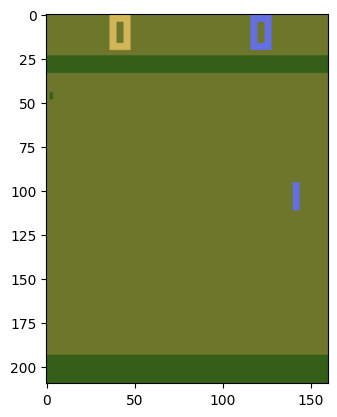

In [ ]:
import gym
import matplotlib.pyplot as plt

# Create the environment with the desired render mode
env = gym.make("Pong-v0", render_mode="rgb_array")

env.seed(42)
frame = env.reset()

# Now calling render() returns an rgb_array frame
random_frame = env.render()
print(random_frame.shape)
plt.imshow(random_frame)
plt.show()

In [ ]:
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return observation_frame.astype(float)

(80, 80)


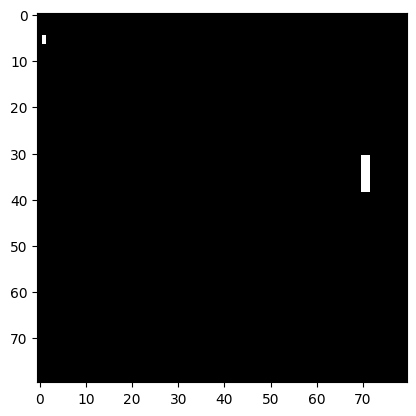

In [ ]:
preprocessed_random_frame = frame_preprocessing(random_frame)
plt.imshow(preprocessed_random_frame, cmap="gray")
print(preprocessed_random_frame.shape)

In [ ]:
rng = np.random.default_rng(seed=12288743)


In [ ]:
D = 80 * 80


In [ ]:
H = 200


In [ ]:
model = {}


In [ ]:
model["W1"] = rng.standard_normal(size=(H, D)) / np.sqrt(D)
model["W2"] = rng.standard_normal(size=H) / np.sqrt(H)


In [ ]:
def policy_forward(x, model):
    # Matrix-multiply the weights by the input in the one and only hidden layer.
    h = np.dot(model["W1"], x)
    # Apply non-linearity with ReLU.
    h[h < 0] = 0
    # Calculate the "dot" product in the outer layer.
    # The input for the sigmoid function is called logit.
    logit = np.dot(model["W2"], h)
    # Apply the sigmoid function (non-linear activation).
    p = sigmoid(logit)
    # Return a log probability for the action 2 ("move up")
    # and the hidden "state" that you need for backpropagation.
    return p, h

In [ ]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [ ]:
def policy_backward(eph, epdlogp, model):
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model["W2"])
    dh[eph <= 0] = 0
    dW1 = np.dot(dh.T, epx)
    # Return new "optimized" weights for the policy network.
    return {"W1": dW1, "W2": dW2}

In [ ]:
# All preprocessed observations for the episode.
xs = []
# All hidden "states" (from the network) for the episode.
hs = []
# All gradients of probability actions
# (with respect to observations) for the episode.
dlogps = []
# All rewards for the episode.
drs = []

In [ ]:
decay_rate = 0.99


In [ ]:
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}


In [ ]:
rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}


In [ ]:
gamma = 0.99


def discount_rewards(r, gamma):
    discounted_r = np.zeros_like(r)
    running_add = 0
    # From the last reward to the first...
    for t in reversed(range(0, r.size)):
        # ...reset the reward sum
        if r[t] != 0:
            running_add = 0
        # ...compute the discounted reward
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [ ]:
max_episodes = 3


In [ ]:
batch_size = 3
learning_rate = 1e-4

In [ ]:
render = False
observation = env.reset()


In [ ]:
prev_x = None
running_reward = None
reward_sum = 0
episode_number = 0


def update_input(prev_x, cur_x, D):
    if prev_x is not None:
        x = cur_x - prev_x
    else:
        x = np.zeros(D)
    return x

In [ ]:
# Initialize environment and variables outside the loop
observation, info = env.reset()
prev_x = None
episode_number = 0
reward_sum = 0

while episode_number < max_episodes:
    if render:
        env.render()

    # Preprocess current frame
    cur_x = frame_preprocessing(observation).ravel()

    # For the first frame, you might want to set prev_x = cur_x
    if prev_x is None:
        prev_x = cur_x

    # Prepare input for the policy network
    x = update_input(prev_x, cur_x, D)
    prev_x = cur_x

    # Forward pass through the policy network
    aprob, h = policy_forward(x, model)

    # Choose action based on probability
    action = 2 if rng.uniform() < aprob else 3

    # Save intermediate variables for backpropagation
    xs.append(x)
    hs.append(h)
    y = 1 if action == 2 else 0  # target label
    dlogps.append(y - aprob)

    # Take action in the environment
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Accumulate reward and store it
    reward_sum += reward
    drs.append(reward)

    # If the episode has finished
    if done:
        episode_number += 1

        # Stack episode data
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)

        # Reset episode buffers
        xs, hs, dlogps, drs = [], [], [], []

        # Discount and normalize rewards
        discounted_epr = discount_rewards(epr, gamma)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        # Ensure epdlogp and discounted_epr have the same number of rows
        min_len = min(len(epdlogp), len(discounted_epr))
        epdlogp = epdlogp[:min_len]
        discounted_epr = discounted_epr[:min_len]

        # Multiply gradients by the advantage
        epdlogp *= discounted_epr

        # Backpropagation and gradient accumulation
        grad = policy_backward(eph, epdlogp, model)
        for k in model:
            grad_buffer[k] += grad[k]

        # Update parameters every batch_size episodes
        if episode_number % batch_size == 0:
            for k, v in model.items():
                g = grad_buffer[k]
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g ** 2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v)

        # Update running reward and print results
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print("Resetting the Pong environment. Episode total reward: {} Running mean: {}".format(reward_sum, running_reward))

        # Reset the environment and variables for the next episode
        observation, info = env.reset()
        prev_x = None
        reward_sum = 0

    # Optionally print when a non-zero reward is received
    if reward != 0:
        print("Episode {}: Game finished. Reward: {}...".format(episode_number, reward) + ("" if reward == -1 else " POSITIVE REWARD!"))

Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: 1.0... POSITIVE REWARD!
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: 1.0... POSITIVE REWARD!
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Resetting the Pong environment. Episode tota

In [ ]:
# Install Xvfb and X11 dependencies.
!apt-get install -y xvfb x11-utils > /dev/null 2>&1
# To work with videos, install FFmpeg.
!apt-get install -y ffmpeg > /dev/null 2>&1
# Install PyVirtualDisplay for visual feedback and other libraries/dependencies.
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate > /dev/null 2>&1

In [ ]:
# Import the virtual display module.
from pyvirtualdisplay import Display
# Import ipythondisplay and HTML from IPython for image and video rendering.
from IPython import display as ipythondisplay
from IPython.display import HTML

# Initialize the virtual buffer at 400x300 (adjustable size).
# With Xvfb, you should set `visible=False`.
display = Display(visible=False, size=(400, 300))
display.start()

# Check that no display is present.
# If no displays are present, the expected output is `:0`.
!echo $DISPLAY

# Define a helper function to display videos in Jupyter notebooks:.
# (Source: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/)

import sys
import math
import glob
import io
import base64

def show_any_video(mp4video=0):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[mp4video]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                                            loop controls style="height: 400px;">
                                            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                                            </video>'''.format(encoded.decode('ascii'))))

    else:
        print('Could not find the video!')


:1


In [ ]:
show_any_video(-1)

Could not find the video!
